In [1]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data, dt_to_float, get_prediction_dates
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

## Get the data

In [25]:
num_forecast_steps = 7 * 4 # 28 days

X_original, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data(add_ones=True)
dates_as_float = np.array([dt_to_float(d) for d in dates]).astype(np.float64)

prediction_dates, prediction_dates_strs = get_prediction_dates(subsample_rate=10)
prediction_date = prediction_dates[0]
                             
# dates > 2000 should give us approximately 10 years of training data
useful_idxs = dates >= datetime(prediction_date.year - 10, 1, 1)
train_idxs = np.logical_and(dates <= prediction_date, useful_idxs)
test_idxs = np.logical_and(dates > prediction_date, useful_idxs)

# num_data_to_consider = 365 * 10 # 10 years worth of data
# assert(num_data_to_consider > num_forecast_steps)

anoms_train = anoms[train_idxs]
clims_train = clims[train_idxs]
temps_train = temps[train_idxs]
dates_train = dates[train_idxs]
dates_as_float_train = dates_as_float[train_idxs]

anoms_test = anoms[test_idxs][:28]
clims_test = clims[test_idxs][:28]
temps_test = temps[test_idxs][:28]
dates_test = dates[test_idxs][:28]
dates_as_float_test = dates_as_float[test_idxs][:28]

anoms = np.concatenate((anoms_train, anoms_test), axis=0)
clims = np.concatenate((clims_train, clims_test), axis=0)
temps = np.concatenate((temps_train, temps_test), axis=0)
dates = np.concatenate((dates_train, dates_test), axis=0)
dates_as_float = np.concatenate((dates_as_float_train, dates_as_float_test), axis=0)

print(f"Num in training set: {len(anoms_train)}")
print(f"Num in testing set: {len(anoms_test)}")

is_predicting_anomaly = False
if is_predicting_anomaly:
    Y_train = anoms_train#.astype(np.float64)
    Y_test = anoms_test#.astype(np.float64)
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train#.astype(np.float64)
    Y_test = temps_test#.astype(np.float64)
    print(f"Y is temperature directly!")


['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 42.0, lon_oi: 251.0
Num in training set: 3758
Num in testing set: 28
Y is temperature directly!


In [19]:
normalize_features = True
X_train = np.copy(X_original[train_idxs])
X_test = np.copy(X_original[test_idxs][:28])
if normalize_features:
    for col_idx in range(X_train.shape[1]):
        if index_to_columnstr[col_idx] == 'ones':
            continue
        vals_train = X_train[:, col_idx]
        vals_test = X_test[:, col_idx]
        mean = np.mean(X_train[:, col_idx])        
        std = np.std(X_train[:, col_idx])
        X_train[:, col_idx] = (vals_train - mean) / std
        X_test[:, col_idx] = (vals_test - mean) / std
X = np.concatenate((X_train, X_test), axis=0)


(3786, 19)
(3758,)
(3758, 19)


(3758,)


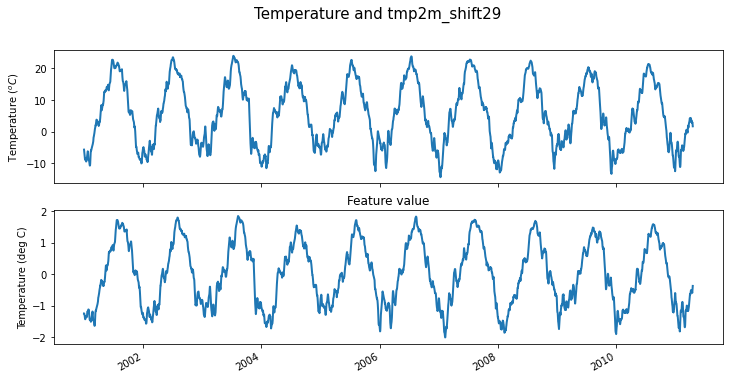

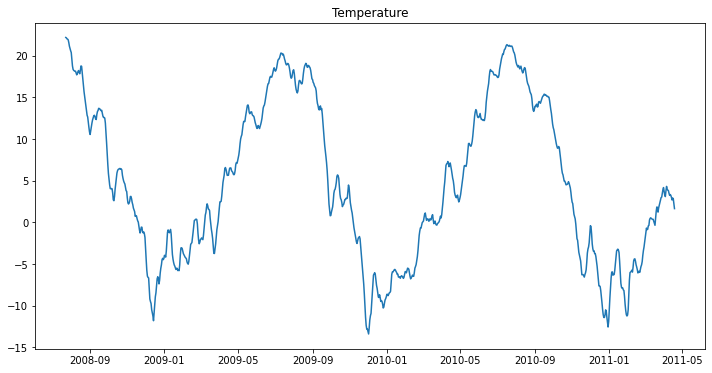

In [4]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "tmp2m_shift29"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title("Feature value")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [5]:
def build_model(observed_time_series):
    annual = tfp.sts.SmoothSeasonal(
        period=365,
        frequency_multipliers=[1, 2, 4, 12],
        initial_state_prior=tfd.MultivariateNormalDiag(scale_diag=tf.ones([8])),
        observed_time_series=observed_time_series,
        name='annual'
    )
    features_effects = []
    features_effects.append(
        tfp.sts.LinearRegression(
            design_matrix=X,# - np.mean(X),
            name=f"linear_regression"
        )
    )
#     for feature_name, idx in columnstr_to_index.items():
#         features_effects.append(
#             tfp.sts.LinearRegression(
#                 design_matrix=np.expand_dims(X[:, idx], 1),# - np.mean(X),
#                 name=f"lr_{feature_name}_{idx}"
#             )
#         )
    sts_components = [
        annual,
    ] + features_effects
    model = tfp.sts.Sum(
        sts_components,
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)


In [20]:
num_variational_steps = 60
optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=temperature_model.joint_log_prob(
            observed_time_series=Y_train),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
    return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds for training")


122.67386817932129 seconds for training


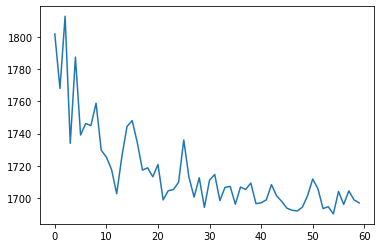

tf.Tensor(
[1801.7568 1767.9204 1812.7152 1734.0233 1787.3987 1739.1019 1746.3004
 1744.8856 1758.8326 1729.6868 1725.4342 1717.7236 1702.7169 1725.7107
 1744.4049 1748.0311 1734.3291 1717.3196 1718.7675 1713.1998 1720.8087
 1698.878  1704.577  1705.285  1709.8595 1735.9971 1713.033  1700.6362
 1712.599  1694.2362 1711.1134 1714.6497 1698.4503 1706.6608 1707.2257
 1696.2057 1706.8436 1705.3666 1709.297  1696.5499 1697.0817 1698.9056
 1708.3315 1701.3958 1697.8871 1693.7274 1692.4491 1692.015  1694.3665
 1701.4618 1711.8323 1705.902  1693.4939 1694.6608 1690.1865 1704.1344
 1696.0872 1704.4541 1698.9049 1697.0121], shape=(60,), dtype=float32)


In [21]:
plt.plot(elbo_loss_curve)
plt.show()
print(elbo_loss_curve)

In [22]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.007790935691446066 +- 0.0038454951718449593
annual/_drift_scale: 0.1712813824415207 +- 0.002103328239172697
linear_regression/_weights: [-3.5033837e-02  6.8757927e-01 -5.6764078e-01 -1.0572300e-01
 -8.1784897e-02  8.3602928e-02  1.6787624e-02  9.0360090e-02
 -5.8800615e-02  4.8255887e-02 -3.4068057e-03  1.7608974e+00
 -5.7633066e-01  6.4308912e-01  4.7869548e-01 -2.9865083e-01
  5.2075779e-01 -5.1869173e+00  5.7715300e-02] +- [0.15424761 0.17751047 0.03673496 0.13075866 0.03292987 0.10196697
 0.04555152 0.20387822 0.04957313 0.06032275 0.00784981 1.0540991
 0.24094547 0.21324126 0.67788845 0.16893247 0.13302505 0.5977788
 0.17047395]


## Forecasting

In [23]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train,
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

time elapsed = 91.50092959403992


0.9532611


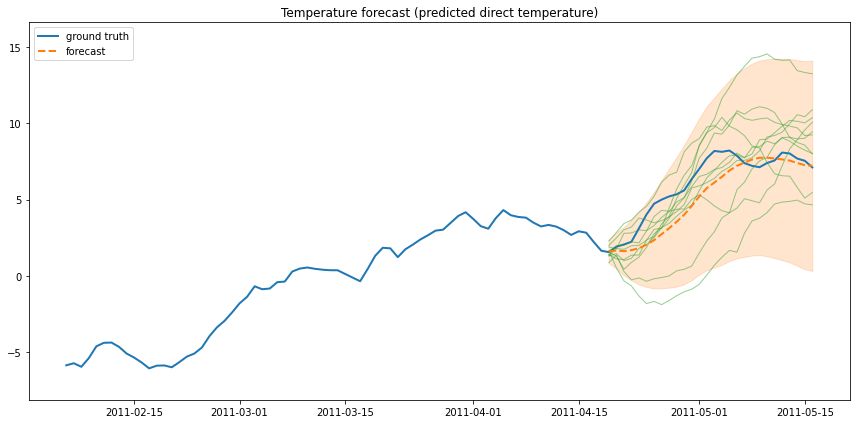

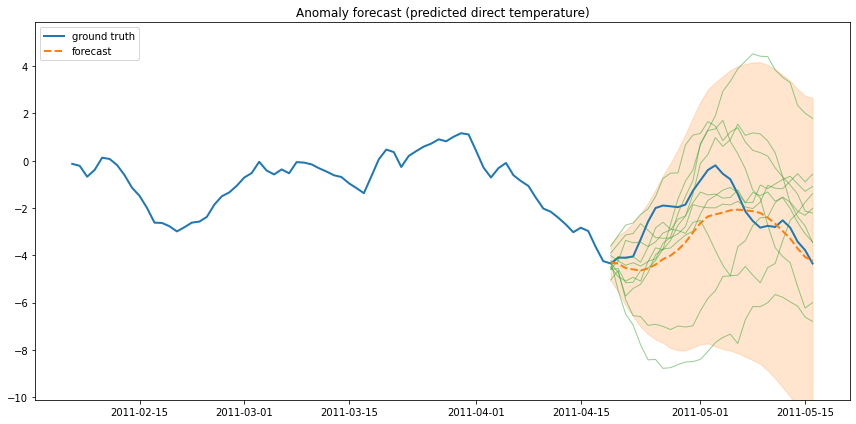

In [26]:
num_samples=10
plot_num = 100

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, anoms + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()
    fig, ax = plot_forecast(dates, anoms,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Anomaly forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    
    anoms_hat = temperature_forecast_mean[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")

    
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct temperature)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    fig, ax = plot_forecast(dates, anoms,
                        temperature_forecast_mean - clims_test[:28],
                        temperature_forecast_scale,
                        temperature_forecast_samples - clims_test[:28],
                        title="Anomaly forecast (predicted direct temperature)",
                        plot_num=plot_num,
    )
    fig.tight_layout()
    
    
    anoms_hat = temperature_forecast_mean[14:] - clims_test[14:num_forecast_steps]
    anoms_gt = anoms_test[14:num_forecast_steps]
    def calculate_skill(a_hat, a):
        return a_hat.dot(a) / (np.linalg.norm(a_hat) * np.linalg.norm(a))

    skill = calculate_skill(anoms_hat.squeeze(), anoms_gt.squeeze())
    print(skill)



In [11]:
num_to_plot_for_decomp = 10 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


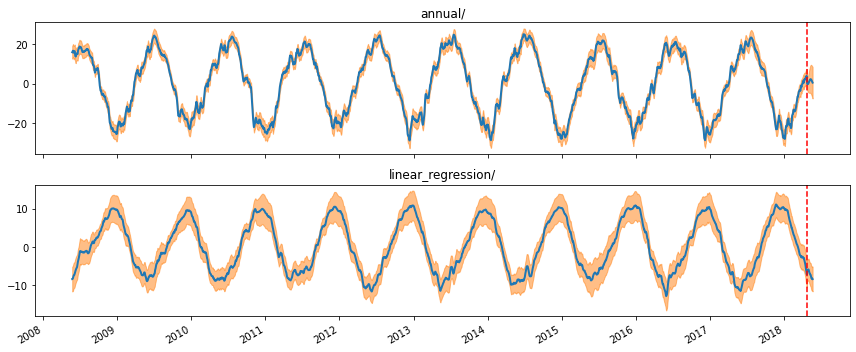

In [12]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = num_to_plot_for_decomp
)
for ax in axes.values():
  ax.axvline(dates[-num_forecast_steps], linestyle="--", color='red')


In [13]:
# Inferred parameters:
# observation_noise_scale: 0.04473809897899628 +- 0.0005243789637461305
# annual/_drift_scale: 0.16907106339931488 +- 0.0043038250878453255
# linear_regression/_weights: [-0.13378933  0.13586834 -0.46769425  0.5908555  -0.1816937   0.12575217
#  -0.0125389   0.08657184 -0.08299268 -0.08857662  0.01435564  2.0131342
#  -0.59601057  0.74958205  0.19609492 -0.01877008  0.63200426 -5.4931445
#   0.12627839] +- [0.14269628 0.15700042 0.02979385 0.22275448 0.02069674 0.09519414
#  0.03187548 0.1613827  0.09067288 0.07632203 0.01582641 0.7954395
#  0.38099194 0.24310967 1.1156161  0.31591898 0.19516274 0.52213377
#  0.12124426]


In [14]:
# linear_regression/_weights: [-0.1924842   1.6874816  -0.96367556  2.1851983  -0.6751628   0.37147996
#   0.03132666  0.09689916 -0.27348262 -0.2448258   0.03529998  1.1408154
#  -0.37922436  0.9595635   0.6977137   0.0787249   0.56584376 -3.2433681
#   0.35618034] +- [0.26395458 0.26421353 0.10910565 0.2455735  0.09417851 0.17340992
#  0.10590971 0.4665144  0.09868016 0.12811695 0.02815794 1.0853078
#  0.99810374 0.53738457 1.2397512  0.34456772 0.57881755 1.2294118
#  0.26190695]


In [15]:
# time elapsed: 271.8489215373993 seconds, skill: 0.958266019821167
        
#         linear_regression/_weights': {'mean': array([ 1.2822413 , -0.6840404 ,  1.3481103 , -0.43651366,  0.03
# 59549 ,
#        -0.00833384,  0.0520747 ,  0.01877282,  0.14969756,  0.0218822 ,
#         1.3367653 , -0.30215457,  0.28519744,  0.55082875, -0.11197992,
#         0.4504398 , -4.9068675 , -0.18384667], dtype=float32), 'std': array([0.10888465, 0.03644544, 0.15358576, 0.02877515, 0.0815364 ,
#        0.06469608, 0.17444547, 0.0668649 , 0.05494722, 0.01645308,
#        1.0591903 , 0.33804527, 0.17797796, 0.63659334, 0.15047185,
#        0.19767031, 0.6690259 , 0.0837003 ],